In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-consumer-finance-complaints/database.sqlite
/kaggle/input/us-consumer-finance-complaints/consumer_complaints.csv


### Dataset being used: US Consumer Finance Complaints

In [2]:
df = pd.read_csv("../input/us-consumer-finance-complaints/consumer_complaints.csv")
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [3]:
df.shape

(555957, 18)

In [4]:
subset_df = df[['product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company', 'company_response_to_consumer']]
subset_df.head()

,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company,company_response_to_consumer
0,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,U.S. Bancorp,Closed with explanation
1,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,Wells Fargo & Company,Closed with explanation
2,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,Wells Fargo & Company,Closed with explanation
3,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,"Navient Solutions, Inc.",Closed with explanation
4,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,Resurgent Capital Services L.P.,Closed with explanation


In [5]:
subset_df['company'].value_counts()

Bank of America                  55998
Wells Fargo & Company            42024
JPMorgan Chase & Co.             33881
Equifax                          31828
Experian                         30905
                                 ...  
S Foreman & Associates Inc           1
JP Development, Inc.                 1
Smith & Smith Investors LTD          1
Palisades Funding Corporation        1
Stonebridge Lending Inc.             1
Name: company, Length: 3605, dtype: int64

In [6]:
subset_df['company'].nunique()

3605

In [7]:
df['company_response_to_consumer'].value_counts()

Closed with explanation            404293
Closed with non-monetary relief     70237
Closed with monetary relief         38262
Closed without relief               17909
Closed                              13399
Closed with relief                   5305
In progress                          3763
Untimely response                    2789
Name: company_response_to_consumer, dtype: int64

## EDA

## Questions to answer from Tableau:

1. Which product and sub-product had the highest complaints
2. Which company recieved the highest complaint and in what product
3. Which company and what products were closed unexpectdely or are in progress
4. Which date/year were maximum complaints lodged company wise

In [26]:
# Here we need to focus on topic modelling of consumer complaints and analyzing how good the topics were.
# subseting the data with consumer complaints narrative present

narrative_df = subset_df[['product','consumer_complaint_narrative']]
narrative_df = narrative_df[narrative_df['consumer_complaint_narrative'].notna()]
narrative_df.head()

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


## Text Cleaning

In [27]:
from nltk.tokenize import word_tokenize
# from nltk.tokenize import TweetTokenizer -- specifically made for tweets to remove @, #, emoticons
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


def clean_text(text):
    
    # tokenize
    tokens = word_tokenize(str(text))
    
    # lower case
    tokens = [w.lower() for w in tokens]
    
    # remove punctuation
    punctuations = string.punctuation
    tokens = [w for w in tokens if w not in punctuations]
    
    # removing tokens that are not alphabetic
    tokens = [w for w in tokens if not w.isdigit()]
    
    # remove stop words
    ADDITIONAL_STOPWORDS = ['hello']
    stop_words = set(stopwords.words('english') + ADDITIONAL_STOPWORDS)
    tokens = [w for w in tokens if w not in stop_words]
    
    # stem
    porter = PorterStemmer()
    tokens = [porter.stem(w) for w in tokens]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    
    
    return tokens
    

# Test String
test_string = "Hello, my name is Prakriti, my email has @, I like Sketching and have 2 cats"
cleaned_string = clean_text(test_string)
cleaned_string

['name', 'prakriti', 'email', 'like', 'sketch', 'cat']

In [10]:
narrative_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 1 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   consumer_complaint_narrative  66806 non-null  object
dtypes: object(1)
memory usage: 1.0+ MB


In [11]:
narrative_df.describe()

,consumer_complaint_narrative
count,66806
unique,65646
top,This company continues to report on my credit ...
freq,37


In [12]:
# to convert the column of objects to string - not required here because I included this while tokenizing
narrative_df.consumer_complaint_narrative.apply(str)

190126    XXXX has claimed I owe them {$27.00} for XXXX ...
190135    Due to inconsistencies in the amount owed that...
190155    In XX/XX/XXXX my wages that I earned at my job...
190207    I have an open and current mortgage with Chase...
190208    XXXX was submitted XX/XX/XXXX. At the time I s...
                                ...                        
553084    XXXX XXXX is reporting incorrectly, payments h...
553085    Reflecting incorrect payment status. Have been...
553086    I have been paying {$180.00} a month through d...
553090    I recently became aware that Amerisave Mortgag...
553096    Bank of America has demonstrated an on-going l...
Name: consumer_complaint_narrative, Length: 66806, dtype: object

In [28]:
## In the interest of time, taking only 10k complaints for now
narrative_df = narrative_df[0:10000]
narrative_df.shape

(10000, 2)

In [29]:
narrative_df['complaints_tokenized'] = df['consumer_complaint_narrative'].apply(lambda x: clean_text(x))
narrative_df.head()

,product,consumer_complaint_narrative,complaints_tokenized
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,"[xxxx, claim, owe, 27.00, xxxx, year, despit, ..."
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,"[due, inconsist, amount, owe, told, bank, amou..."
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,"[xx/xx/xxxx, wage, earn, job, decreas, almost,..."
190207,Mortgage,I have an open and current mortgage with Chase...,"[open, current, mortgag, chase, bank, xxxx, ch..."
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,"[xxxx, submit, xx/xx/xxxx, time, submit, compl..."


In [ ]:
# resetting index
narrative_df = narrative_df.reset_index(drop=True)

## Bag of Words Model

In [30]:
import gensim

processed_docs = narrative_df.complaints_tokenized
dictionary = gensim.corpora.Dictionary(processed_docs)

# removing too frequent and too rare words
# no_below: words appearing less than 10 times in the corpus
# no_above: Words appearing more than 50% of the times in the corpus
# keep_n: keep only the first n most frequent tokens
dictionary.filter_extremes(no_below = 10, no_above = 0.5, keep_n = 100000)

# converting Dict to BOW
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [31]:
# printing bag of words of a specific complaint

bow_doc = bow_corpus[1190]

for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} times".format(bow_doc[i][0], dictionary[bow_doc[i][0]], bow_doc[i][1]))

Word 3 ("bill") appears 12 times
Word 15 ("paid") appears 1 times
Word 16 ("payment") appears 10 times
Word 27 ("amount") appears 7 times
Word 28 ("balanc") appears 4 times
Word 31 ("contact") appears 4 times
Word 33 ("credit") appears 6 times
Word 37 ("due") appears 4 times
Word 42 ("given") appears 1 times
Word 50 ("made") appears 1 times
Word 55 ("offer") appears 1 times
Word 56 ("one") appears 1 times
Word 60 ("pay") appears 7 times
Word 61 ("per") appears 2 times
Word 64 ("receiv") appears 4 times
Word 65 ("remain") appears 3 times
Word 69 ("request") appears 2 times
Word 73 ("show") appears 1 times
Word 74 ("still") appears 1 times
Word 77 ("told") appears 3 times
Word 78 ("total") appears 1 times
Word 83 ("write") appears 1 times
Word 84 ("yet") appears 1 times
Word 85 ("100.00") appears 1 times
Word 87 ("account") appears 2 times
Word 92 ("also") appears 2 times
Word 95 ("appli") appears 2 times
Word 98 ("back") appears 1 times
Word 99 ("base") appears 2 times
Word 103 ("call")

## LDA using BOW

In [32]:
narrative_df.head()

,product,consumer_complaint_narrative,complaints_tokenized
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,"[xxxx, claim, owe, 27.00, xxxx, year, despit, ..."
190135,Consumer Loan,Due to inconsistencies in the amount owed that...,"[due, inconsist, amount, owe, told, bank, amou..."
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,"[xx/xx/xxxx, wage, earn, job, decreas, almost,..."
190207,Mortgage,I have an open and current mortgage with Chase...,"[open, current, mortgag, chase, bank, xxxx, ch..."
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,"[xxxx, submit, xx/xx/xxxx, time, submit, compl..."


The LDA algorithm has a number of parameters than can be used to calibrate the output:

1. num_topics: In this example we have prescribed a number 10, in a previous run without a prescribed number, the LDA produced 99 clusters which is not very informative for our usecase

2. id2word: The previously defined dictionary mapping from word IDs to Words

3. Workers: for parralelisation

4. chunksize: number of documents to use in each training chunk

5. passes: no. passes through the corpus during training

6. alpha: Can be set to an 1D array of length equal to the number of expected topics that expresses our a-priori belief for the each topics’ probability.

7. decay: A number between (0.5, 1] to weight what percentage of the previous lambda value is forgotten when each new document is examined.

8. iterations: Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.

9. gamma_threshold: Minimum change in the value of the gamma parameters to continue iterating.

In [54]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 6, id2word = dictionary, passes =2)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
lda_model.print_topics

for i,topic in lda_model.print_topics(-1):
    print("Topic: {} \n Words: {}".format(i, topic))

Topic: 0 
 Words: 0.019*"credit" + 0.016*"bank" + 0.016*"call" + 0.015*"account" + 0.011*"payment" + 0.011*"loan" + 0.010*"receiv" + 0.010*"``" + 0.010*"''" + 0.009*"check"
Topic: 1 
 Words: 0.031*"call" + 0.016*"would" + 0.014*"told" + 0.011*"time" + 0.011*"receiv" + 0.010*"loan" + 0.009*"inform" + 0.008*"payment" + 0.008*"credit" + 0.008*"n't"
Topic: 2 
 Words: 0.021*"payment" + 0.017*"account" + 0.014*"credit" + 0.014*"bank" + 0.010*"report" + 0.008*"ask" + 0.008*"told" + 0.008*"xx/xx/xxxx" + 0.008*"time" + 0.008*"call"
Topic: 3 
 Words: 0.029*"credit" + 0.022*"account" + 0.016*"report" + 0.012*"payment" + 0.012*"debt" + 0.012*"card" + 0.011*"collect" + 0.009*"inform" + 0.007*"loan" + 0.007*"request"
Topic: 4 
 Words: 0.022*"report" + 0.016*"account" + 0.014*"credit" + 0.014*"debt" + 0.011*"call" + 0.010*"file" + 0.009*"n't" + 0.009*"inform" + 0.008*"receiv" + 0.008*"loan"
Topic: 5 
 Words: 0.022*"payment" + 0.021*"loan" + 0.012*"mortgag" + 0.011*"account" + 0.011*"would" + 0.008*"h

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualizing Topics

### Interactive Graph

In [56]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
vis_data = gensimvis.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(vis_data)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Word Cloud representation

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


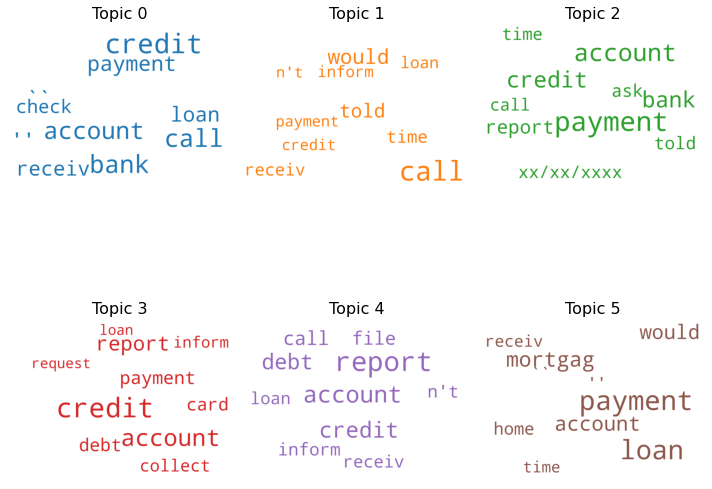

In [59]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Dominant Topic & Percentage Contribution of topics in the documents

### Really good article for code: link to refer:  https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document

In [71]:
def format_topics_sentences(ldamodel=None, corpus=bow_corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']
df_dominant_topic.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,0.0,0.7917,"credit, bank, call, account, payment, loan, re..."
1,1,3.0,0.7243,"credit, account, report, payment, debt, card, ..."
2,2,5.0,0.6264,"payment, loan, mortgag, account, would, home, ..."
3,3,4.0,0.9766,"report, account, credit, debt, call, file, n't..."
4,4,4.0,0.8920,"report, account, credit, debt, call, file, n't..."
5,5,4.0,0.9745,"report, account, credit, debt, call, file, n't..."
6,6,4.0,0.7045,"report, account, credit, debt, call, file, n't..."
7,7,3.0,0.6421,"credit, account, report, payment, debt, card, ..."
8,8,1.0,0.4460,"call, would, told, time, receiv, loan, inform,..."
9,9,5.0,0.4655,"payment, loan, mortgag, account, would, home, ..."


In [ ]:
# removing a column: df_dominant_topic.drop(['Text'], axis=1)

In [69]:
narrative_df.shape

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10000, 3)

In [74]:
df_result = pd.concat([narrative_df, df_dominant_topic], axis=1)
df_result.head(10)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,product,consumer_complaint_narrative,complaints_tokenized,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,"[xxxx, claim, owe, 27.00, xxxx, year, despit, ...",0,0.0,0.7917,"credit, bank, call, account, payment, loan, re..."
1,Consumer Loan,Due to inconsistencies in the amount owed that...,"[due, inconsist, amount, owe, told, bank, amou...",1,3.0,0.7243,"credit, account, report, payment, debt, card, ..."
2,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,"[xx/xx/xxxx, wage, earn, job, decreas, almost,...",2,5.0,0.6264,"payment, loan, mortgag, account, would, home, ..."
3,Mortgage,I have an open and current mortgage with Chase...,"[open, current, mortgag, chase, bank, xxxx, ch...",3,4.0,0.9766,"report, account, credit, debt, call, file, n't..."
4,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,"[xxxx, submit, xx/xx/xxxx, time, submit, compl...",4,4.0,0.8920,"report, account, credit, debt, call, file, n't..."
5,Mortgage,Experian is reporting my OPEN and CURRENT Mort...,"[experian, report, open, current, mortgag, loa...",5,4.0,0.9745,"report, account, credit, debt, call, file, n't..."
6,Mortgage,This complaint is against Wells Fargo Bank for...,"[complaint, well, fargo, bank, violat, term, c...",6,4.0,0.7045,"report, account, credit, debt, call, file, n't..."
7,Mortgage,I spoke to XXXX of green tree representatives ...,"[spoke, xxxx, green, tree, repres, xxxx, xxxx,...",7,3.0,0.6421,"credit, account, report, payment, debt, card, ..."
8,Credit card,i opened XXXX Bank of America credit cards 15-...,"[open, xxxx, bank, america, credit, card, 15-2...",8,1.0,0.4460,"call, would, told, time, receiv, loan, inform,..."
9,Consumer Loan,I applied for a loan with XXXX XXXX and had pu...,"[appli, loan, xxxx, xxxx, purchas, xxxx, vehic...",9,5.0,0.4655,"payment, loan, mortgag, account, would, home, ..."


In [75]:
df_result.to_csv('bow_topic_modelling.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
